In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as tvtf
import glob
from torch.utils.data import DataLoader
import torch.nn.functional as F
import seaborn as sns

/home/mohammadabedi/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def convert_to_float(value):
    return float(value)

In [10]:
device = torch.device('cpu')
main_dataset = torchvision.datasets.ImageFolder("/home/mohammadabedi/Documents/Lip_Movement_Detection/train_data", transform=tvtf.ToTensor(), target_transform=convert_to_float)
train_dataset, val_dataset = torch.utils.data.random_split(main_dataset, [int(125012*0.8), 125012-int(125012*0.8)])
test_dataset = torchvision.datasets.ImageFolder("/home/mohammadabedi/Documents/Lip_Movement_Detection/test_data", transform=tvtf.ToTensor(), target_transform=convert_to_float)

In [11]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True, shuffle=True)

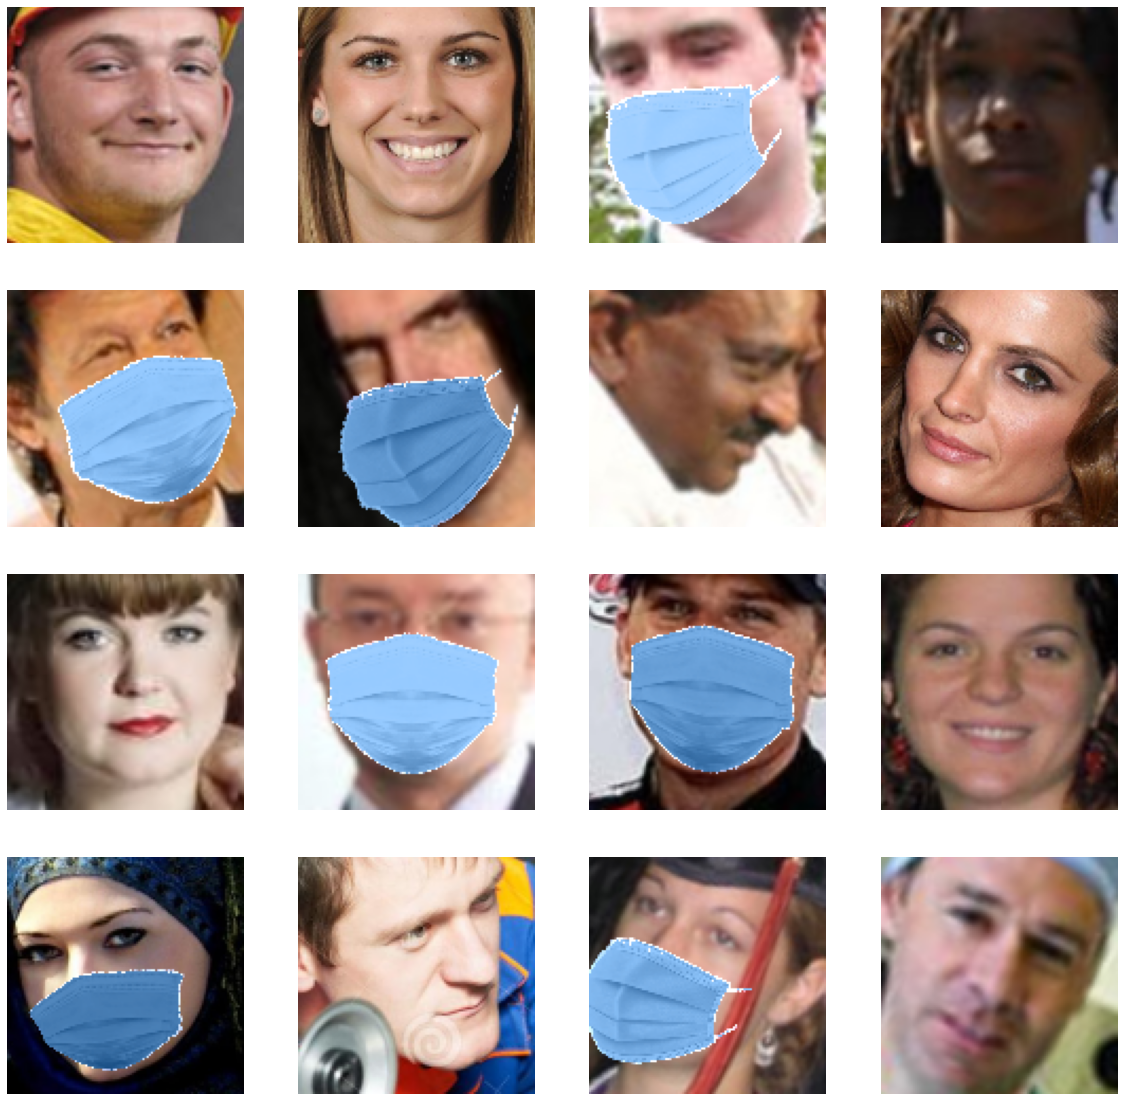

In [12]:
examples = iter(train_loader)
ex_images, ex_labels = next(examples)
plt.figure(figsize=(20, 20))
for i in range(16):
  plt.subplot(4, 4, i+1)
  image = torch.squeeze(ex_images[i]).permute(1, 2, 0)
  plt.imshow(image)
  plt.axis('off')

In [13]:
class Model(nn.Module):
  def __init__(self, initial_filter_size, batch_size):
    super(Model, self).__init__()
    self.batch_size = batch_size
    self.conv1 = nn.Conv2d(3, initial_filter_size, 5, padding='same')
    self.batchn1 = nn.BatchNorm2d(initial_filter_size)
    self.pool = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(initial_filter_size, 2*initial_filter_size, 5, padding='same')
    self.batchn2 = nn.BatchNorm2d(2*initial_filter_size)
    self.conv3 = nn.Conv2d(2*initial_filter_size, 4*initial_filter_size, 3, padding='same')
    self.batchn3 = nn.BatchNorm2d(4*initial_filter_size)
    self.conv4 = nn.Conv2d(4*initial_filter_size, 8*initial_filter_size, 3, padding='same')
    self.batchn4 = nn.BatchNorm2d(8*initial_filter_size)
    self.lin1 = nn.Linear(7*7*8*initial_filter_size, 64)
    self.lin2 = nn.Linear(64, 1)

  def forward(self, x):
    
    x = F.relu(self.conv1(x))
    x = self.batchn1(x)
    x = self.pool(x)

    x = F.relu(self.conv2(x))
    x = self.batchn2(x)
    x = self.pool(x)

    x = F.relu(self.conv3(x))
    x = self.batchn3(x)
    x = self.pool(x)

    x = F.relu(self.conv4(x))
    x = self.batchn4(x)
    x = self.pool(x)
    
    batch = x.shape[0]
    x = x.view([batch, -1])

    x = F.relu(self.lin1(x))
    x = self.lin2(x)

    return x

In [8]:
number_of_epochs = 3
model = Model(2, batch_size).to(device)
loss_f = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(number_of_epochs):
  total_loss = 0.0

  for index, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    preds = model(images)
    preds = preds.squeeze_()
    loss = loss_f(preds, labels)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    total_loss += loss.item()
  
  model.eval()
  val_total_loss = 0
  for index, (val_images, val_labels) in enumerate(val_loader):
    val_images = val_images.to(device)
    val_labels = val_labels.to(device)

    val_preds = model(val_images)
    val_preds = val_preds.squeeze_()
    val_loss = loss_f(val_preds, val_labels)
    
    val_total_loss += val_loss.item()

  print(f'the loss for epoch {epoch+1} is {total_loss} \t the loss for epoch {epoch+1} is {val_total_loss}')

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [128, 1]], which is output 0 of SigmoidBackward0, is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [89]:
total_par = 0
for par in model.parameters():
    if par.requires_grad :
        total_par += par.numel()

print(f"Total number of paramaters for this model is {total_par}") 

Total number of paramaters for this model is 52185


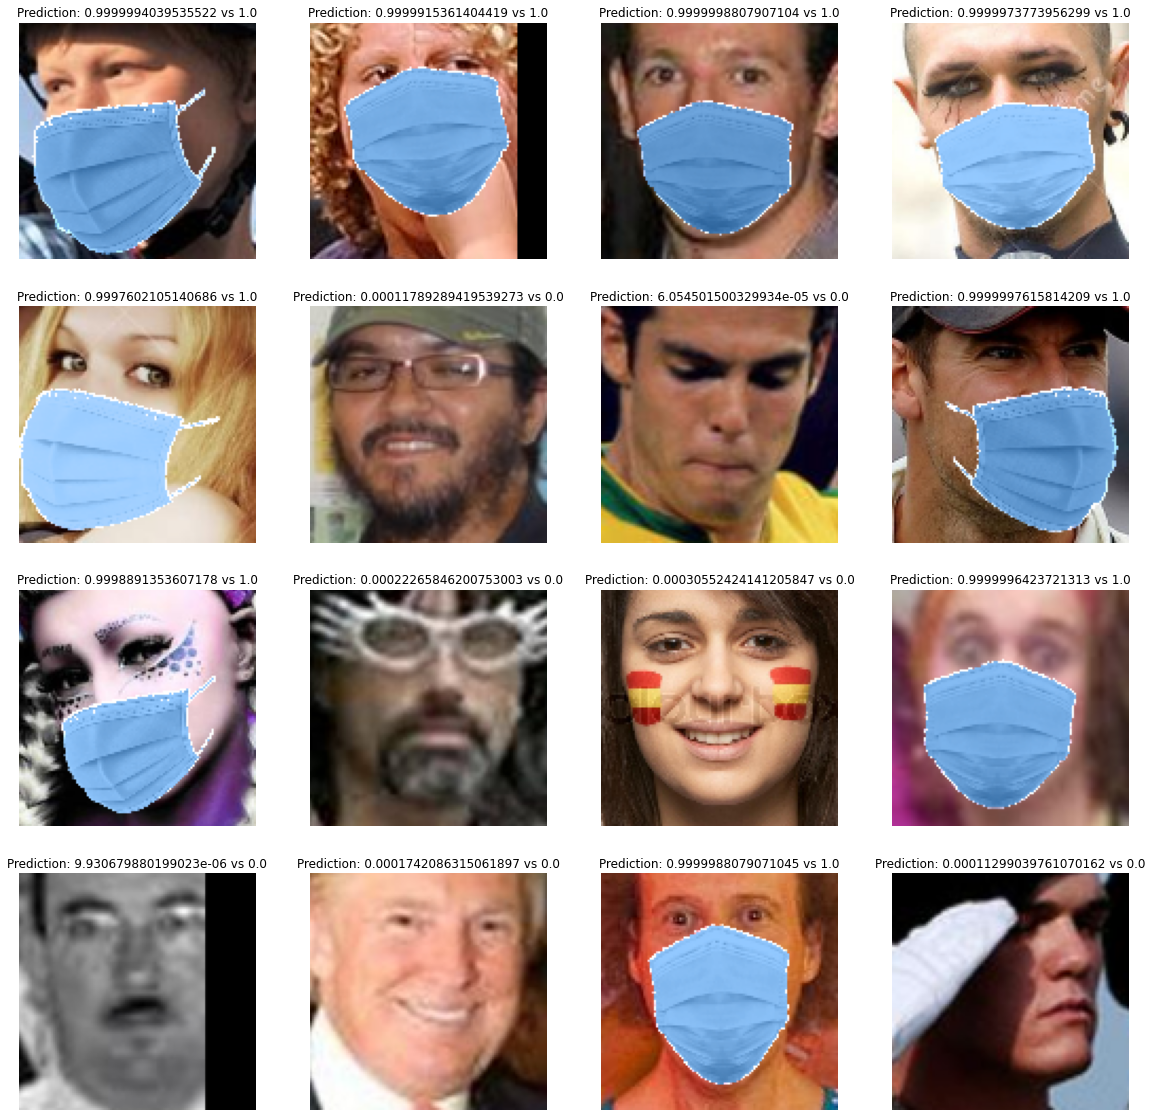

In [9]:
#torch.save(model.state_dict(), "/home/mohammadabedi/Documents/Lip_Movement_Detection/model/model.pt")
new_model = Model(2, batch_size)
new_model.load_state_dict(torch.load("/home/mohammadabedi/Documents/Lip_Movement_Detection/model/model.pt"))

examples = iter(test_loader)
ex_images, ex_labels = next(examples)

plt.figure(figsize=(20, 20))

with torch.no_grad():
    new_model.eval()
    for i in range(16):
        plt.subplot(4, 4, i+1)
        image = torch.squeeze(ex_images[i]).permute(1, 2, 0)
        plt.imshow(image)
        plt.axis('off')
        #print(torch.unsqueeze(ex_images[i], 0).shape)
        pred = new_model(torch.unsqueeze(ex_images[i].to(device), 0))
        plt.title(f"Prediction: {pred.item()} vs {ex_labels[i]}")

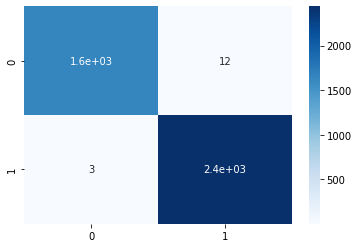

In [10]:
with torch.no_grad():
    new_model.eval()
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for (images, labels) in test_loader:
        preds = new_model(images.to(device))
        preds = torch.round(preds)
        preds = preds.squeeze_()
        tp += sum(preds*labels)
        tn += sum(preds==labels) - sum(preds*labels)
        fp += sum(preds) - sum(preds*labels)
        fn += sum(labels) - sum(preds*labels)

    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    F1score = 2*precision*recall/(precision + recall)
    cm = [[tp, fp], [fn, tn]]
    sns.heatmap(cm, cmap='Blues', annot=True)

In [14]:
number_of_epochs = 3
main_model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

for param in main_model.parameters():
    param.requires_grad = False

num_out_features = main_model.fc.in_features
main_model.fc = nn.Linear(num_out_features, 1)
#main_model = nn.Sequential(main_model, nn.Sigmoid(inplace=False))

main_model = main_model.to(device)

loss_f2 = nn.BCEWithLogitsLoss()

optimizer2 = torch.optim.Adam(main_model.fc.parameters(), lr=0.001)

for epoch in range(number_of_epochs):
  total_loss = 0.0

  for index, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    preds = main_model(images)
    preds = preds.squeeze_()
    loss = loss_f2(preds, labels)

    loss.backward()
    optimizer2.step()
    optimizer2.zero_grad()
    
    total_loss += loss.item()
  
  main_model.eval()
  val_total_loss = 0
  for index, (val_images, val_labels) in enumerate(val_loader):
    val_images = val_images.to(device)
    val_labels = val_labels.to(device)

    val_preds = main_model(val_images)
    val_preds = val_preds.squeeze_()
    val_loss = loss_f2(val_preds, val_labels)
    
    val_total_loss += val_loss.item()

  print(f'the loss for epoch {epoch+1} is {total_loss} \t the validatoin loss for epoch {epoch+1} is {val_total_loss}')

KeyboardInterrupt: 

In [53]:
for param in main_model[0].fc.parameters():
    print(param)

TypeError: 'ResNet' object is not subscriptable